<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/ml-for-finance-intro/blob/main/2026/01-notebooks/nb-lesson-2-1.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Data Preprocessing

## Introduction 

In the previous lecture we spent quite some time understanding where financial data come from and why they cannot be treated as ordinary datasets. Now we move to what in many machine learning courses is presented as a preliminary technical step: preprocessing. In finance this is not a preliminary step at all. It is part of the model itself. The moment we modify data we are making assumptions about the economic mechanism that generated them, and small decisions taken here can completely change the outcome of a backtest. Very often what looks like predictive power is simply a consequence of how the data were prepared.

You should therefore constantly keep one question in mind while listening to this lecture: am I removing noise, or am I removing information? Because in financial datasets the two are frequently confused.

Data pre-processing introduces several key concepts that are **transversal to all of machine learning**. Among these, **handling missing values, feature scaling, encoding categorical variables, and detecting outliers** are crucial. These techniques ensure that the input data is structured, consistent, and suitable for training robust models. Without proper data preparation, models may struggle with convergence, exhibit bias, or fail to generalize to new data.

To develop intuition for these ideas, we will use **simple datasets** as our primary tool. This choice allows us to focus on the core issues of **data cleaning, transformation, and feature engineering** without being overwhelmed by complex datasets or domain-specific knowledge. By using well-defined examples, we can systematically explore how different pre-processing techniques affect the model’s performance.

In this lesson, we will cover the essential components of data pre-processing, including:

- **Handling missing data: imputation and removal strategies**
- **Feature scaling: normalization and standardization**
- **Encoding categorical variables**
- **Detecting and handling outliers**
- **Feature Selection and Dimensionality Reduction**

By mastering these principles early, we establish a solid foundation that will allow us to prepare datasets effectively for any machine learning application. With these concepts in place, we can confidently proceed to building and validating models, knowing that our data is well-structured and optimized for success.

## Dealing with missing data

We begin from missing values. In most areas of machine learning missing data are accidental. A sensor failed, a value was not recorded, a form was incomplete. In finance the situation is very different. A missing price may indicate that no transaction occurred. A firm may stop reporting precisely when its situation deteriorates. A borrower may omit some information strategically. A macroeconomic series may appear late because of reporting delays. So the absence of a number is often itself informative. It may be telling us something about liquidity, distress, opacity or market stress.

Statistically we distinguish several mechanisms that generate missing observations. Sometimes values are missing independently of the data, but in financial datasets this is rare. More commonly missingness depends on other observed variables — for instance smaller firms reporting less frequently. And quite often missingness depends on the unobserved value itself, which is exactly what happens when distressed firms stop publishing unfavorable information. Now think about what happens if we simply delete these observations. We systematically remove bad outcomes from the dataset. The model will then conclude that the world is safer than it really is, not because markets are stable but because we erased instability before estimation.

For this reason deletion is almost never neutral. It feels conservative because we avoid inventing numbers, but in practice it introduces selection bias. Imagine a dataset of mutual funds where returns disappear when the fund closes. Dropping missing values leaves only surviving funds, and average performance becomes unrealistically high. The model did not discover a profitable strategy — we constructed a biased history.

A second common reaction is replacing missing values with an average. This looks reasonable but has another dangerous effect. Suppose returns are missing exactly during turbulent periods. Replacing them with the mean artificially smooths the series and reduces measured volatility. The dataset now describes a calmer market than the one investors actually faced. In other words we hide risk precisely where it was largest.

There is another crucial constraint: time. When we fill a missing observation at time t we must use only information available up to that moment. Forward filling, rolling averages based on past windows, or cross-sectional averages computed at the same date are acceptable. Using the full sample mean is not. If we use information from the future to reconstruct the past, even indirectly, the algorithm will learn patterns that never existed in reality. Backtests will look impressive and collapse in live trading. This is the first encounter with the concept of information leakage: giving the model access to knowledge it would not have had at prediction time.

Let's create
a simple example data frame from a comma-separated values (CSV) file to get
a better grasp of the problem:

In [7]:
import pandas as pd
#
# The StringIO module is an in-memory file-like object. This object can be used as input or output 
# to the most function that would expect a standard file object. When the StringIO object is created 
# it is initialized by passing a string to the constructor. If no string is passed the StringIO will 
# start empty. In both cases, the initial cursor on the file starts at zero. NOTE: This module does 
# not exist in the latest version of Python so to work with this module we have to import it from 
# the io module.
#
from io import StringIO

csv_data = \
    '''
    A,B,C,D
    1.0,2.0,3.0,4.0
    5.0,6.0,,8.0
    10.0,11.0,12.0,
    10.0,11.0,12.0,13.0
    '''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN
3,10.0,11.0,12.0,13.0


### Delete Rows with Missing Values 

One of the easiest ways to deal with missing data is simply to remove the
corresponding features (columns) or training examples (rows) from the dataset
entirely. Missing values can be handled by deleting the rows or columns having null values. If columns have more than half of the rows as null then the entire column can be dropped. The rows which are having one or more columns values as null can also be dropped.

Remember that, in pandas, rows with missing values can easily be dropped via the **dropna** method:

In [8]:
df1 = df.dropna(axis=0)
df1

,A,B,C,D
0,1.0,2.0,3.0,4.0
3,10.0,11.0,12.0,13.0


In [9]:
df2 = df.dropna(axis=1)
df2

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0
3,10.0,11.0


Although the removal of missing data seems to be a convenient approach, it also
comes with certain disadvantages; for example, we may end up removing too
many samples, which will make a reliable analysis impossible. Or, if we remove too
many feature columns, we will run the risk of losing valuable information that our
classifier needs to discriminate between classes. In the next section, we will look
at one of the most commonly used alternatives for dealing with missing values:
interpolation techniques.

**Pros**:
- A model trained with the removal of all missing values creates a robust model.

**Cons**:
- Loss of a lot of information.
- Works poorly if the percentage of missing values is excessive in comparison to the complete dataset.

### Imputing missing values

One of the most common interpolation
techniques is called **imputation**, where we simply replace the missing value with
the mean value of the entire feature column. 

>**scikit-learn - SimpleImputer**
>
>A convenient way to achieve this is by
>using the **SimpleImputer** class from scikit-learn. Scikit-learn, infact,  has built-in methods to perform these  preprocessing steps. For example, the `SimpleImputer()` fills in missing values using a method of your choice (see the code >below). The Scikit-learn documentation lists the full options for data preprocessing [here](https://scikit-learn.org/stable/modules/preprocessing.html).

In [10]:
from sklearn.impute import SimpleImputer
import numpy as np
#
# define the imputing method
#
imr = SimpleImputer(missing_values=np.nan, strategy='mean')

imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)

imputed_data

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  9.        ,  8.        ],
       [10.        , 11.        , 12.        ,  8.33333333],
       [10.        , 11.        , 12.        , 13.        ]])

Alternatively, an even more convenient way to impute missing values is by using
pandas' **fillna** method and providing an imputation method as an argument. For
example, using pandas, we could achieve the same mean imputation directly in the
DataFrame object via the following command:

In [11]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.000000
1,5.0,6.0,9.0,8.000000
2,10.0,11.0,12.0,8.333333
3,10.0,11.0,12.0,13.000000


**Pros**:
- Prevent data loss which results in deletion of rows or columns
- Works well with a small dataset and is easy to implement.

**Cons**:
- Works only with numerical continuous variables.
- Can cause data leakage
- Do not factor the covariance between features.

### The Best Way: Introduce Missingness Indicator

A better idea is not to hide missingness but to make it visible. For each variable we create an indicator that records whether the value was originally present or absent. Then we fill the missing value using a simple rule — often the median or a past observation — but we keep the indicator as an additional feature. The model now knows both the imputed number and the fact that it was reconstructed. In financial contexts this is extremely useful because lack of information often signals illiquidity or uncertainty. Instead of guessing the value, we let the model learn that missingness itself carries meaning.

In [12]:
df = pd.DataFrame({
    'leverage': [0.4, np.nan, 0.7, np.nan, 0.5]
})
# Create missingness indicator
df['leverage_missing'] = df['leverage'].isna().astype(int)
# Impute with median
median_val = df['leverage'].median()
df['leverage_imp'] = df['leverage'].fillna(median_val)
print(df)

   leverage  leverage_missing  leverage_imp
0       0.4                 0           0.4
1       NaN                 1           0.5
2       0.7                 0           0.7
3       NaN                 1           0.5
4       0.5                 0           0.5


In [13]:
df = pd.DataFrame({
    'leverage': [0.4, np.nan, 0.7, np.nan, 0.5]
})

# Create imputer with indicator
imputer = SimpleImputer(
    strategy='median',
    add_indicator=True  # Automatically adds missingness flags
)
df_imp = imputer.fit_transform(df)
df_imp

array([[0.4, 0. ],
       [0.5, 1. ],
       [0.7, 0. ],
       [0.5, 1. ],
       [0.5, 0. ]])

### Identify and Delete Zero-Variance Predictors

Zero-variance predictors refer to input features that contain a single value across the entire spectrum of observations. Accordingly, they do not add any value to the prediction algorithm since the target variable is not affected by the input value, making them redundant. Some ML algorithms might also run into unexpected errors or output wrong results.
Pandas provides a function to count and list the number of unique values in each column of a Pandas dataframe:

In [14]:
csv_data = \
data_string = '''A,B,C,D,E,F,G,H
1.0,2.0,3.0,4.0,5.0,6.0,7.0,42.0
5.0,2.0,7.0,8.0,5.0,6.0,11.0,42.0
9.0,6.0,11.0,12.0,9.0,10.0,15.0,42.0
13.0,6.0,15.0,16.0,9.0,10.0,19.0,42.0
17.0,10.0,19.0,20.0,13.0,14.0,23.0,42.0
21.0,10.0,23.0,24.0,13.0,14.0,27.0,42.0
25.0,14.0,27.0,28.0,17.0,18.0,31.0,42.0
29.0,14.0,31.0,32.0,17.0,18.0,35.0,42.0
33.0,18.0,35.0,36.0,21.0,22.0,39.0,42.0
37.0,18.0,39.0,40.0,21.0,22.0,43.0,42.0'''

df = pd.read_csv(StringIO(csv_data))
# Get number of rows and columns
num_rows, num_columns = df.shape
print(num_rows, num_columns)
df

10 8


,A,B,C,D,E,F,G,H
0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,42.0
1,5.0,2.0,7.0,8.0,5.0,6.0,11.0,42.0
2,9.0,6.0,11.0,12.0,9.0,10.0,15.0,42.0
3,13.0,6.0,15.0,16.0,9.0,10.0,19.0,42.0
4,17.0,10.0,19.0,20.0,13.0,14.0,23.0,42.0
5,21.0,10.0,23.0,24.0,13.0,14.0,27.0,42.0
6,25.0,14.0,27.0,28.0,17.0,18.0,31.0,42.0
7,29.0,14.0,31.0,32.0,17.0,18.0,35.0,42.0
8,33.0,18.0,35.0,36.0,21.0,22.0,39.0,42.0
9,37.0,18.0,39.0,40.0,21.0,22.0,43.0,42.0


In [15]:
df.nunique()

A    10
B     5
C    10
D    10
E     5
F     5
G    10
H     1
dtype: int64

The code below will drop all columns that have a single value and update the df dataframe.

In [16]:
df2 = df.drop(columns = df.columns[df.nunique() == 1],inplace = False)
print(df2)
print(df)

      A     B     C     D     E     F     G
0   1.0   2.0   3.0   4.0   5.0   6.0   7.0
1   5.0   2.0   7.0   8.0   5.0   6.0  11.0
2   9.0   6.0  11.0  12.0   9.0  10.0  15.0
3  13.0   6.0  15.0  16.0   9.0  10.0  19.0
4  17.0  10.0  19.0  20.0  13.0  14.0  23.0
5  21.0  10.0  23.0  24.0  13.0  14.0  27.0
6  25.0  14.0  27.0  28.0  17.0  18.0  31.0
7  29.0  14.0  31.0  32.0  17.0  18.0  35.0
8  33.0  18.0  35.0  36.0  21.0  22.0  39.0
9  37.0  18.0  39.0  40.0  21.0  22.0  43.0
      A     B     C     D     E     F     G     H
0   1.0   2.0   3.0   4.0   5.0   6.0   7.0  42.0
1   5.0   2.0   7.0   8.0   5.0   6.0  11.0  42.0
2   9.0   6.0  11.0  12.0   9.0  10.0  15.0  42.0
3  13.0   6.0  15.0  16.0   9.0  10.0  19.0  42.0
4  17.0  10.0  19.0  20.0  13.0  14.0  23.0  42.0
5  21.0  10.0  23.0  24.0  13.0  14.0  27.0  42.0
6  25.0  14.0  27.0  28.0  17.0  18.0  31.0  42.0
7  29.0  14.0  31.0  32.0  17.0  18.0  35.0  42.0
8  33.0  18.0  35.0  36.0  21.0  22.0  39.0  42.0
9  37.0  18.0  3

In [17]:
df.drop(columns = df.columns[df.nunique() == 1], inplace = True)
df

,A,B,C,D,E,F,G
0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
1,5.0,2.0,7.0,8.0,5.0,6.0,11.0
2,9.0,6.0,11.0,12.0,9.0,10.0,15.0
3,13.0,6.0,15.0,16.0,9.0,10.0,19.0
4,17.0,10.0,19.0,20.0,13.0,14.0,23.0
5,21.0,10.0,23.0,24.0,13.0,14.0,27.0
6,25.0,14.0,27.0,28.0,17.0,18.0,31.0
7,29.0,14.0,31.0,32.0,17.0,18.0,35.0
8,33.0,18.0,35.0,36.0,21.0,22.0,39.0
9,37.0,18.0,39.0,40.0,21.0,22.0,43.0


> **pandas remind**: Here’s a concise reminder of the key **pandas** syntax properties used in the given instruction:
>
>1. **`df.nunique()`**  
>   - Returns the number of unique values for each column in the DataFrame.
>
>2. **`df.columns[...]`**  
>   - Retrieves the column labels of the DataFrame.
>   - `df.columns[df.nunique() == 1]` selects columns where all values are the same (i.e., with only one unique value).
>
>3. **`df.drop(columns=...)`**  
>   - Drops the specified columns from the DataFrame.
>   - `inplace=False` ensures that the original DataFrame remains unchanged, returning a new modified DataFrame (`df2` in this >case). 

## Outlier Detection in Financial Data

Once missing values are addressed we encounter another characteristic of financial data: extreme observations. In many datasets an extreme value is likely an error. In finance it may be the most important event in the sample — a crash, a default, a liquidity shock. Removing extreme values blindly removes the phenomenon we want to study. Financial returns are known to have heavy tails, meaning large movements occur more frequently than a normal distribution would predict. Because of this, classical detection rules based on standard deviations are unreliable. What appears abnormal under Gaussian assumptions may be perfectly plausible in markets. For example:

- Extreme observations frequently correspond to economically meaningful events — market stress, liquidity dry-ups, sudden information arrivals, or regime changes — rather than measurement errors. Consequently, outlier detection is not merely a data-cleaning step but part of modeling the underlying data-generating process.

- Financial return distributions are typically heavy-tailed, meaning that extreme values occur more often than predicted by Gaussian assumptions. For this reason, classical techniques based on standard deviations (e.g., simple Z-scores) may incorrectly classify genuine risk realizations as anomalies. Robust statistical methods, such as the Interquartile Range (IQR) and the Median Absolute Deviation (MAD), are therefore more appropriate because they remain stable in the presence of heavy tails. 

We rely on robust statistics based on quantiles, such as the interquartile range or the median absolute deviation. These methods identify observations that are unusual relative to the empirical distribution rather than relative to an unrealistic theoretical one. But detection is only half the problem. Once we identify extremes we must decide what they represent. If an observation is clearly a recording error, we remove it. If it corresponds to an actual market event, deletion destroys information about risk.

The objective of this analysis is to distinguish between two fundamentally different situations:

* **Data errors**, which should be corrected or removed
* **Tail events**, which must be preserved because they carry risk information

After detection, different treatments will be explored — including winsorization and transformation — always with the constraint of preserving economic meaning and avoiding distortions in downstream models. The goal is not to “sanitize” the dataset, but to construct a representation that remains statistically robust while retaining the financial information contained in extreme observations.

### Robust Outlier Detection: IQR and MAD

Because financial variables often exhibit heavy tails, outlier detection should rely on statistics that are insensitive to extreme observations. Two widely used robust measures are the **Interquartile Range (IQR)** and the **Median Absolute Deviation (MAD)**. Both avoid the instability of mean- and variance-based approaches and therefore remain reliable when extreme market moves are present.

#### Interquartile Range (IQR)

The IQR measures the spread of the central portion of the distribution using quantiles rather than the mean and standard deviation.

Let
$$
Q_1 = \text{25th percentile}, \qquad Q_3 = \text{75th percentile}
$$

$$
\text{IQR} = Q_3 - Q_1
$$

The idea is simple: instead of asking *how far a point is from the mean*, we ask whether it lies outside the typical middle 50% of observations.

An observation $x_i$ is flagged as an outlier if

$$
x_i < Q_1 - k \cdot \text{IQR}
\quad \text{or} \quad
x_i > Q_3 + k \cdot \text{IQR}
$$

with $k = 1.5$ as the standard choice.

**Interpretation.**
The IQR method defines outliers as values incompatible with the central bulk of the distribution. Since quartiles are stable even when extreme returns occur, the method remains reliable in heavy-tailed financial data. 

#### Median Absolute Deviation (MAD)

MAD is even more robust because it measures dispersion around the **median** using absolute deviations.

First compute the median:

$$
m = \text{median}(x)
$$

Then

$$
\text{MAD} = \text{median}(|x_i - m|)
$$

To identify outliers, we build a *robust Z-score*:

$$
M_i = 0.6745 \cdot \frac{x_i - m}{\text{MAD}}
$$

An observation is typically flagged when

$$
|M_i| > 3.5
$$

**Interpretation.**
MAD estimates variability using only relative distances from the median, making it extremely resistant to extreme values. For financial returns — where large shocks are common — MAD is often preferable to standard deviation–based thresholds. 

#### Key Difference

IQR identifies observations outside the central bulk of the distribution, while MAD evaluates how unusual a point is relative to a robust estimate of scale. In practice, IQR works well for general exploratory analysis, whereas MAD is particularly suited to strongly heavy-tailed financial series.

### A Practical Example of Outlier Detection Analysis

#### Read Data from File

In [29]:
import matplotlib.pyplot as plt

file_path = "apple_price_returns.xlsx"

df = pd.read_excel(file_path)

In [30]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).set_index("date").sort_index()
df.head()

,price,return
date,,
2023-01-04,124.365677,0.010262
2023-01-05,123.046806,-0.010661
2023-01-06,127.574211,0.036133
2023-01-09,128.095856,0.004081
2023-01-10,128.666672,0.004446


#### Implementing Outlier Detection

In [31]:
def detect_outliers_iqr(series, k=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    
    mask = (series < lower) | (series > upper)
    return mask, lower, upper

In [32]:
# Example usage
mask_iqr, lower, upper = detect_outliers_iqr(df['return'])

In [33]:
print("Outliers trovati (IQR):", mask_iqr.sum())

Outliers trovati (IQR): 42


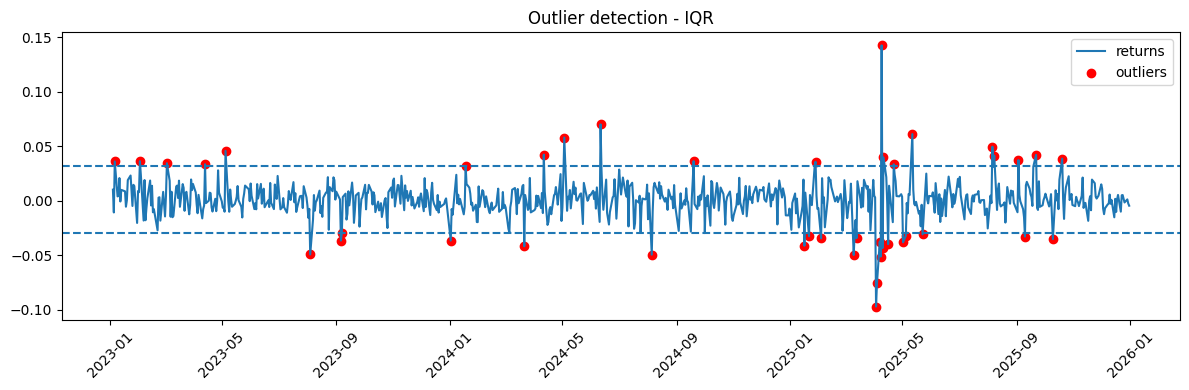

In [34]:
import matplotlib.dates as mdates

r = df['return']

plt.figure(figsize=(12,4))
plt.plot(r.index, r, label="returns")

plt.scatter(r.index[mask_iqr], r[mask_iqr], color="red", label="outliers")

plt.axhline(upper, linestyle="--")
plt.axhline(lower, linestyle="--")

# formattazione asse temporale
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.legend()
plt.title("Outlier detection - IQR")
plt.tight_layout()
plt.show()


In [35]:
def outliers_mad(series, threshold=3.5):
    median = np.median(series)
    mad = np.median(np.abs(series - median))
    
    modified_z = 0.6745 * (series - median) / mad
    mask = np.abs(modified_z) > threshold
    
    return mask, modified_z

In [36]:
mask_mad, score = outliers_mad(df['return'])
print("Outliers MAD:", mask_mad.sum())

Outliers MAD: 19


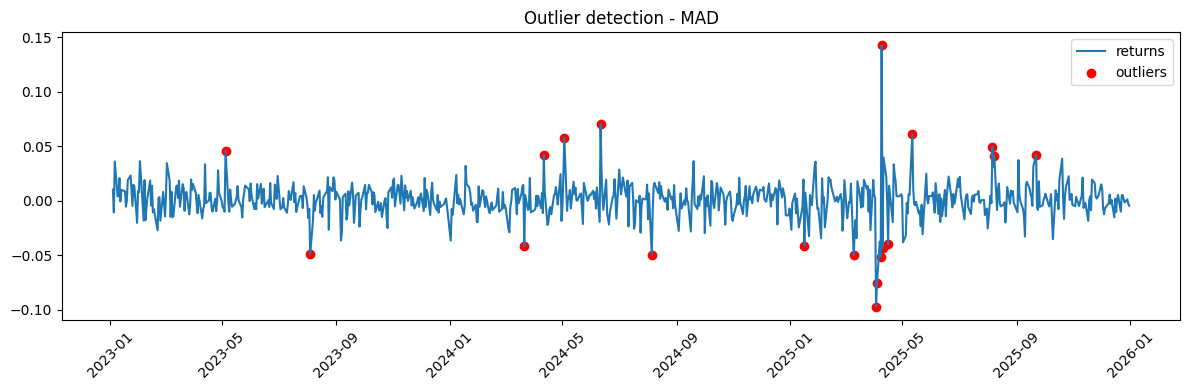

In [37]:
import matplotlib.dates as mdates

r = df['return']

plt.figure(figsize=(12,4))
plt.plot(r.index, r, label="returns")

plt.scatter(r.index[mask_mad], r[mask_mad], color="red", label="outliers")

# formattazione asse temporale
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.legend()
plt.title("Outlier detection - MAD")
plt.tight_layout()
plt.show()


In [38]:
df.loc[mask_mad, ["price","return"]]

,price,return
date,,
2023-05-05,171.091385,0.045859
2023-08-04,179.639252,-0.049211
2024-03-21,169.824448,-0.041716
2024-04-11,173.461349,0.042361
2024-05-03,181.726135,0.058095
2024-06-11,205.560165,0.070131
2024-08-05,207.663940,-0.049366
2025-01-16,227.019867,-0.041239
2025-03-10,226.492844,-0.049694


#### Compare with Price Time Series

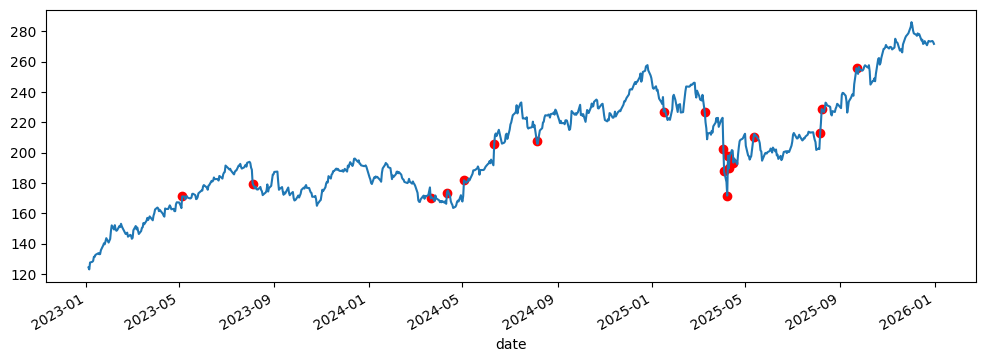

In [39]:
df["price"].plot(figsize=(12,4))
plt.scatter(df.index[mask_mad], df["price"][mask_mad], color="red")

In [40]:
df["abs_ret"] = df["return"].abs()
df.sort_values("abs_ret", ascending=False).head(10)

,price,return,abs_ret
date,,,
2025-04-09,197.987091,0.142617,0.142617
2025-04-03,202.308258,-0.097013,0.097013
2025-04-04,187.562531,-0.075680,0.075680
2024-06-11,205.560165,0.070131,0.070131
2025-05-12,210.150482,0.061233,0.061233
2024-05-03,181.726135,0.058095,0.058095
2025-04-08,171.671799,-0.051102,0.051102
2025-03-10,226.492844,-0.049694,0.049694
2025-08-06,212.603027,0.049653,0.049653


#### Dividend Analysis

In [41]:
import yfinance as yf

ticker = "AAPL"
stock = yf.Ticker(ticker)

# Serie storica dividendi
dividends = stock.dividends

# rimuove timezone (UTC -> naive)
dividends.index = dividends.index.tz_localize(None)

dividends.head()

Date
1987-05-11    0.000536
1987-08-10    0.000536
1987-11-17    0.000714
1988-02-12    0.000714
1988-05-16    0.000714
Name: Dividends, dtype: float64

In [42]:
start = df.index.min()
end   = df.index.max()
print(start, end)

2023-01-04 00:00:00 2025-12-31 00:00:00


In [43]:
dividends = dividends.loc[start:end]

In [44]:
df["dividend"] = 0.0
df.loc[df.index.intersection(dividends.index), "dividend"] = dividends

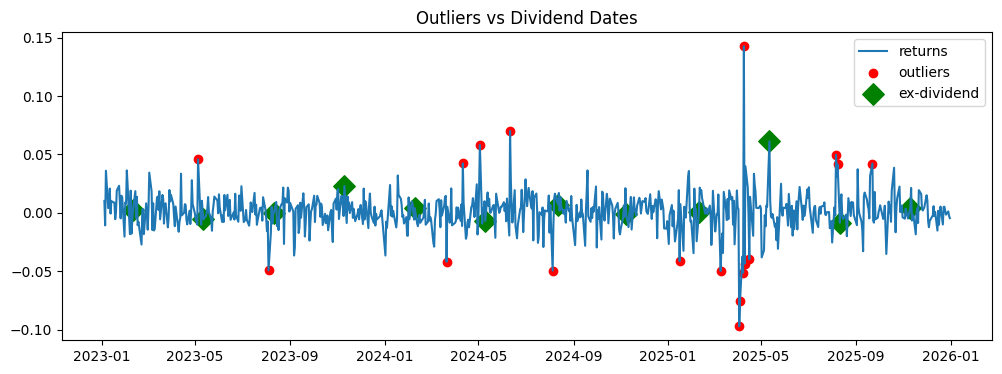

In [45]:
plt.figure(figsize=(12,4))

# rendimenti
plt.plot(df.index, df["return"], label="returns")

# outliers MAD
plt.scatter(df.index[mask_mad], df["return"][mask_mad],
            color="red", label="outliers")

# dividendi
plt.scatter(dividends.index,
            df.loc[dividends.index, "return"],
            color="green", s=120, marker="D", label="ex-dividend")

plt.legend()
plt.title("Outliers vs Dividend Dates")
plt.show()


In [46]:
check = df.loc[mask_mad].copy()
check["is_dividend"] = check.index.isin(dividends.index)

check[["price","return","is_dividend"]]
check[check['is_dividend']==True]

,price,return,abs_ret,dividend,is_dividend
date,,,,,
2025-05-12,210.150482,0.061233,0.061233,0.26,True


#### Splits Analysis

In [47]:
splits = stock.splits
splits.head()

Date
1987-06-16 00:00:00-04:00    2.0
2000-06-21 00:00:00-04:00    2.0
2005-02-28 00:00:00-05:00    2.0
2014-06-09 00:00:00-04:00    7.0
2020-08-31 00:00:00-04:00    4.0
Name: Stock Splits, dtype: float64

#### Volatility Analysis

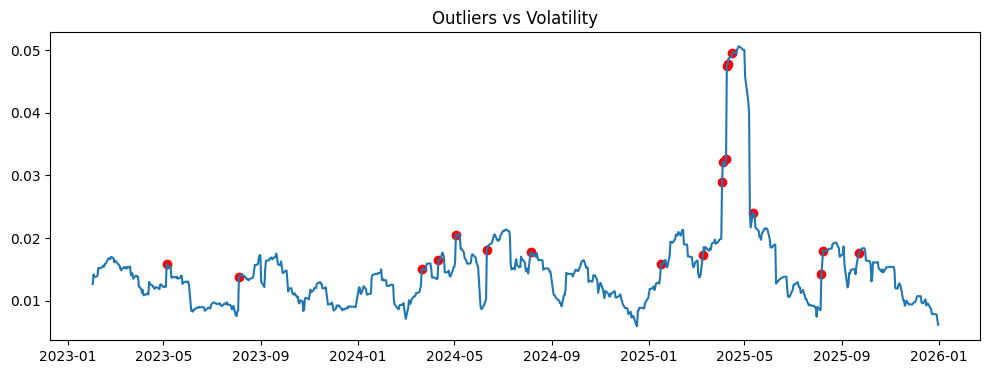

In [90]:
vol = df["return"].rolling(20).std()

plt.figure(figsize=(12,4))
plt.plot(vol)
plt.scatter(df.index[mask_mad], vol[mask_mad], color="red")
plt.title("Outliers vs Volatility")
plt.show()

The detected extreme observations are not randomly scattered over time but **clearly cluster during periods of elevated market volatility**. Their occurrence does not coincide with dividend dates and no stock splits are present in the analyzed interval, excluding corporate actions as a mechanical source of large returns. Moreover, the largest deviations appear within sustained volatility regimes rather than as isolated spikes followed by immediate reversals, which would typically indicate data errors. These features suggest that the flagged points are **genuine realizations** from the tails of the return distribution rather than artifacts of data collection. Consequently, **they should be interpreted as economically meaningful market shocks carrying information about risk**, and not removed as statistical anomalies, although specific modeling choices may require robust transformations rather than deletion.

---

## Feature Normalization

Many machine learning algorithms require that the selected features are on
the same scale for optimal performance, this process is called "Feature Normalization" and is the subject of this paragraph.

Data Normalization is a common practice in machine learning which consists of transforming numeric columns to a common scale. In machine learning, some feature values differ from others multiple times. The features with higher values will dominate the leaning process. However, it does not mean those variables are more important to predict the outcome of the model. Data normalization transforms multiscaled data to the same scale. After normalization, all variables have a similar influence on the model, improving the stability and performance of the learning algorithm.

There are multiple normalization techniques in statistics. In this notebook, we will cover the most important ones:

- The maximum absolute scaling
- The min-max feature scaling
- The z-score method

### The maximum absolute scaling

The maximum absolute scaling rescales each feature between -1 and 1 by dividing every observation by its maximum absolute value.

$$
x_{new} = \frac{x_{old}}{\max \vert x_{old} \vert}
$$

### The min-max feature scaling

The min-max approach (often called normalization) rescales the feature to a fixed range of [0,1] by subtracting the minimum value of the feature and then dividing by the range:

$$
x_{new} = \frac{x_{old}-x_{min}}{x_{max}-x_{min}}
$$

The min-max scaling procedure is implemented in scikit-learn and can be used as
follows:

In [ ]:
#
# Here we have to load the file 'salary_vs_age_1.csv'
#
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()
    path = ''
else:
    path = './data/'

In [ ]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
# Read data from file 'salary_vs_age_1.csv' 
# (in the same directory that your python process is based)
# Control delimiters, with read_table 
df1 = pd.read_table(path + "salary_vs_age_1.csv", sep=";") 
# Preview the first 5 lines of the loaded data 
print(df1.head())

columns_titles = ["Salary","Age"]
df2=df1.reindex(columns=columns_titles)
df2

df2['Salary'] = df2['Salary']/1000 
df2['Age2']=df2['Age']**2
df2['Age3']=df2['Age']**3
df2['Age4']=df2['Age']**4
df2['Age5']=df2['Age']**5
df2

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
df3 = pd.DataFrame(mms.fit_transform(df2))
df3

### Z-Score

The **z-score** method (often called **standardization**) transforms the data into a distribution with a mean of 0 and a standard deviation of 1. Each standardized value is computed by subtracting the mean of the corresponding feature and then dividing by the standard deviation.

$$
x_{new} = \frac{x_{old} - \mu}{\sigma}
$$

Unlike min-max scaling, the z-score does not rescale the feature to a fixed range. The z-score typically ranges from -3.00 to 3.00 (more than 99% of the data) if the input is normally distributed.

It is important to bear in mind that z-scores are not necessarily normally distributed. They just scale the data and follow the same distribution as the original input. This transformed distribution has a mean of 0 and a standard deviation of 1 and is going to be the standard normal distribution only if the input feature follows a normal distribution.

Standardization can easily be achieved by using the built-in NumPy methods mean
and std:

In [ ]:
import numpy as np

X = np.array([6, 7, 7, 12, 13, 13, 15, 16, 19, 22])

X_std = np.copy(X)
X_std = (X - X.mean()) / X.std()

print(X_std)

Or simply using the specific function of the stats module of scipy

In [ ]:
import scipy.stats as stats

stats.zscore(X)

Standardization is very useful with gradient descent learning. In this case
the optimizer has to go through fewer steps to find a good or optimal solution (the
global cost minimum).

Similar to the MinMaxScaler class, scikit-learn also implements a class for
standardization:

In [ ]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
df4 = pd.DataFrame(stdsc.fit_transform(df2))
df4

**A Word of Caution**

The Z score ihis implicitly assumes stable variance and roughly symmetric distributions — assumptions frequently violated in financial data due to heavy tails and regime changes. Min-Max transformation maps values into a fixed interval using observed minima and maxima. This is extremely sensitive to new extremes and therefore unstable over time. More robust approaches rely on medians and quantiles or on ranking observations relative to their peers. The key point is that scaling is not cosmetic. It defines what the algorithm perceives as large or small, and therefore influences how it interprets importance.

---

## Categorical Data

Categorical data is a form of data that takes on values within a finite set of discrete classes. It is difficult to count or measure categorical data using numbers and therefore they are divided into categories: **ordinal** and **nominal** features. 

**Ordinal** features can be understood as categorical
values that *can be sorted or ordered*. For example, t-shirt size would be an ordinal
feature, because we can define an order: XL > L > M. 

In contrast, **nominal** features
don't imply any order and, to continue with the previous example, we could think
of t-shirt color as a nominal feature since it typically doesn't make sense to say that,
for example, red is larger than blue.

### Encoding

Before we explore different techniques for handling such categorical data, let's create a new DataFrame to illustrate the problem:

In [ ]:
# Define possible S&P ratings
ratings = ["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "CC", "C", "D"]

num_samples = 10

# Generate an updated synthetic dataset
df = pd.DataFrame({
    "rating": np.random.choice(ratings, num_samples),                 # Random S&P rating assignment
    "income": np.random.randint(20000, 200000, num_samples),          # Income in dollars
    "age": np.random.randint(18, 75, num_samples),                    # Age of the individual
    "employment_status": np.random.choice(["Employed", "Unemployed", "Self-Employed"], num_samples),
    "loan_amount": np.random.randint(5000, 500000, num_samples),      # Loan amount in dollars
    "default_history": np.random.choice(["Yes", "No"], num_samples, p=[0.2, 0.8])  # 20% default history
})

df

> **REMIND - FEATURES AND LABELS**
> ***
> Remember that in machine learning, you have **features** and **labels**. *The features are the **descriptive** attributes*, and *the 
> label is what you're attempting to predict or forecast*. In this simple example, **rating**, **income**, **age**, **employment_status** and **loan_amount** are **features** while 
> **default_history** is the field that contains the **label** of the corresponding record.

To make sure that the learning algorithm interprets the ordinal features correctly,
we need to convert the categorical string values into integers. 

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ratings = [["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "CC", "C", "D"]]

le = OrdinalEncoder(categories=ratings)
df["rating_encoded"] = le.fit_transform(df[["rating"]])
df

In [ ]:
rating_map = {
    "AAA": 0, "AA": 1, "A": 2, "BBB": 3, "BB": 4, 
    "B": 5, "CCC": 6, "CC": 7, "C": 8, "D": 9
}
df["rating_numeric"] = df["rating"].map(rating_map)
df

In [ ]:
df2 = df.drop(columns=["rating", "rating_encoded"], inplace=False)
df2.rename(columns={"rating_numeric":"rating"}, inplace=True)

cols = ["rating"] + [col for col in df2.columns if col != "rating"]
df2 = df2[cols]
df2

### Encoding Class Labels

Many machine learning libraries require that class labels are encoded as integer
values. Although most estimators for classification in scikit-learn convert class
labels to integers internally, it is considered good practice to provide class labels as
integer arrays to avoid technical glitches. To encode the class labels, we can use an
approach similar to the mapping of ordinal features discussed previously. We need
to remember that class labels are not ordinal, and it doesn't matter which integer
number we assign to a particular string label. Thus, we can simply enumerate
the class labels, starting at 0:

<div style = 'background-color:skyblue'>
    <strong>Python Pills</strong>
    <p>
    enumerate() method in Python
    </p>    
    <p>
    Enumerate() method adds a counter to an iterable and returns it in a form of enumerating object. This enumerated object can then be used directly for loops or converted into a list of tuples using the list() method.
    </p>        
</div>

In [ ]:
import numpy as np


class_mapping = {label: idx for idx, label in enumerate(np.unique(df2['default_history']))}
class_mapping

Next, we can use the mapping dictionary to transform the class labels into integers:

In [ ]:
df2['default_history'] = df['default_history'].map(class_mapping)
df2

We can reverse the key-value pairs in the mapping dictionary as follows to map the
converted class labels back to the original string representation:

In [ ]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df2['default_history'] = df2['default_history'].map(inv_class_mapping)
df2

Alternatively, there is a convenient LabelEncoder class directly implemented in
scikit-learn to achieve this:

In [ ]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df2['default_history'].values)
y

### Ordinal Encoding vs Label Encoding: Key Differences

Both **Ordinal Encoding** and **Label Encoding** transform categorical data into numerical values, but they serve different purposes and have distinct behaviors. 

**1. Ordinal Encoding (`OrdinalEncoder`)**

**Concept**:  

- Each unique category is **mapped to an integer** based on a specific order.
- **It preserves the order** of the categories.

**Example: Credit Ratings**
| Rating | Ordinal Encoding |
|---------|----------------|
| CCC     | 0              |
| B       | 1              |
| BB      | 2              |
| BBB     | 3              |
| A       | 4              |
| AA      | 5              |
| AAA     | 6              |

```python
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

data = pd.DataFrame({'rating': ['AAA', 'BB', 'A', 'CCC', 'AA']})

encoder = OrdinalEncoder(categories=[['CCC', 'B', 'BB', 'BBB', 'A', 'AA', 'AAA']])
data['rating_encoded'] = encoder.fit_transform(data[['rating']])

print(data)
```

**When to Use Ordinal Encoding?**

✔ When the categorical variable has an **intrinsic order** (e.g., credit rating, education level, survey ratings). 

❌ Not ideal for unordered categorical variables like `color`, `city`, or `car brands`.

**2. Label Encoding (`LabelEncoder`)**

**Concept**:

- Assigns **a unique integer** to each category **without considering order**.
- The numbers **do not represent any ranking**—they are just arbitrary labels.

**Example: Car Brands**

| Car Brand | Label Encoding |
|-----------|---------------|
| Toyota    | 0             |
| Ford      | 1             |
| BMW       | 2             |
| Tesla     | 3             |

```python
from sklearn.preprocessing import LabelEncoder

data = pd.DataFrame({'car_brand': ['Toyota', 'Ford', 'BMW', 'Tesla', 'Ford']})

encoder = LabelEncoder()
data['brand_encoded'] = encoder.fit_transform(data['car_brand'])

print(data)
```

**When to Use Label Encoding?**

✔ When the categorical variable is **nominal** (i.e., no natural order).  

❌ Not suitable for ordinal variables (e.g., credit ratings), as it might **mislead models into thinking there's an order when there isn’t or viceversa**.

**Key Differences**

| Feature          | Ordinal Encoding | Label Encoding |
|-----------------|----------------|---------------|
| **Preserves Order?** | ✅ Yes | ❌ No |
| **Use Case** | Ordered categories (e.g., credit rating, survey responses) | Unordered categories (e.g., city names, brands) |
| **Assigns Numeric Values?** | ✅ Yes | ✅ Yes |
| **Numbers Represent Ranking?** | ✅ Yes | ❌ No |
| **Risk of Misinterpretation?** | 🚨 If order is incorrect | 🚨 If used on ordinal data |
| **Scikit-Learn Class** | `OrdinalEncoder` | `LabelEncoder` |


**When to Avoid These Encodings?**

If the categorical variable is **nominal** (no order) and has **many unique values**, both methods can cause issues.

### One-hot Encoding

When there is no a natural order we have to resort to a different approach that is to use the technique called **one-hot encoding**.  The idea behind this approach is to create a new dummy feature for each
unique value in the nominal feature column. Here, we would convert the `employment_status`
feature into three new features: *employed*, *self_employed*, and *unemployed*. Binary values can then be used
to indicate the particular employment status of an example; for example, an employed customer can be
encoded as *employed=1, self_employed=0, unemployed=0*. To perform this transformation, we can use the
`OneHotEncoder` that is implemented in `scikit-learn`'s preprocessing module:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X = df2[['employment_status']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

Another way to create those dummy features via one-hot encoding
is to use the get_dummies method implemented in pandas. Applied to a DataFrame,
the get_dummies method will only convert string columns and leave all other
columns unchanged:

In [ ]:
pd.get_dummies(df2[['employment_status']])

---

## Appendix

### Philosophy of Use of Scikit-Learn

Scikit-learn is one of the most widely used Python libraries for machine learning. Its design philosophy is centered on **simplicity, modularity, and consistency**, making it accessible to both beginners and advanced users.

The **core principles** that guide the usage of scikit-learn are:
1. **Unified API**: Every model (regression, classification, clustering, dimensionality reduction, etc.) follows the same pattern.
2. **Minimal Configuration**: Most models work well with default parameters and can be fine-tuned later.
3. **Consistency**: Whether you are dealing with a linear regression, decision tree, or neural network, the interaction with models remains the same.
4. **Pipeline-Oriented**: Scikit-learn encourages a step-by-step workflow involving data preprocessing, model training, and prediction.

#### The Core Methods: `fit()`, `transform()`, `predict()`

Scikit-learn is built around a **three-step workflow**: **fitting**, **transforming**, and **predicting**. Almost every estimator (a model or transformer) in scikit-learn follows these methods.

**1. `fit()` – Learning from Data**

- This method is used to **train** a model or a transformer on the given dataset.
- It extracts relevant patterns, parameters, or statistics from the data.
- Used in **both preprocessing transformers (e.g., scalers, PCA)** and **models (e.g., linear regression, decision trees)**.

**Usage:**

```python
model.fit(X_train, y_train)
```
or, for transformers:
```python
scaler.fit(X_train)
```

**Example: Linear Regression**

```python
from sklearn.linear_model import LinearRegression

X_train = [[1], [2], [3], [4]]
y_train = [2, 4, 6, 8]

model = LinearRegression()
model.fit(X_train, y_train)  # Learns the relationship (y = 2x)
```

**Example: Standard Scaler**

```python
# The scaler methods in scikit-learn are preprocessing techniques used to normalize or 
# standardize numerical data before feeding it into a machine learning model.

from sklearn.preprocessing import StandardScaler

X_train = [[10], [20], [30], [40]]

scaler = StandardScaler()
scaler.fit(X_train)  # Computes mean and standard deviation
```

**2. `transform()` – Applying a Transformation**

- Used **only by transformers** (not predictive models).
- It applies a learned transformation to new data.
- Example use cases:
  - **Feature scaling (e.g., StandardScaler, MinMaxScaler)**
  - **Dimensionality reduction (e.g., PCA)**
  - **Encoding categorical variables (e.g., OneHotEncoder)**

**Usage:**

```python
X_transformed = transformer.transform(X_new)
```

**Example: Standard Scaler**

```python
X_test = [[25], [35]]

X_scaled = scaler.transform(X_test)  # Applies scaling learned from fit()
```

> **Important:** `fit_transform(X)` is a shortcut for `fit(X)` followed by `transform(X)`.

```python
X_scaled = scaler.fit_transform(X_train)  # Often used in pipelines
```

**3. `predict()` – Making Predictions**

- Used **only by predictive models** (not transformers).
- Takes new input data (`X_test`) and outputs predictions (`y_pred`).
- Works with both **classification (e.g., DecisionTreeClassifier, SVM)** and **regression (e.g., LinearRegression, RandomForestRegressor)**.

**Usage:**

```python
y_pred = model.predict(X_test)
```

**Example: Predicting with Linear Regression**

```python
X_test = [[5], [6]]

y_pred = model.predict(X_test)  # Output: [10, 12] (y = 2x)
```

#### How These Methods Fit Together in a Typical Pipeline

A typical **machine learning workflow** in scikit-learn follows these steps:

1. **Preprocess the data** (fit and transform):
   - Handle missing values, scale features, encode categorical variables.
   - Example: `StandardScaler().fit_transform(X)`

<p></p>

2. **Train the model** (fit):
   - Example: `model.fit(X_train, y_train)`

<p></p>

3. **Make predictions** (predict):
   - Example: `y_pred = model.predict(X_test)`

**Example: Full Pipeline**

```python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Define pipeline: Scaling + Linear Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # First, scale features
    ('regressor', LinearRegression())  # Then, fit regression model
])

# Fit pipeline
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)
```

**Key Takeaways**
- `fit()`: **Learns** from the data (used by both transformers and models).
- `transform()`: **Applies** learned transformations (only for transformers).
- `predict()`: **Generates predictions** from trained models (only for predictive models).
- **Scikit-learn enforces a uniform API**, making it easy to switch between models.
- **Pipelines** streamline the workflow by combining preprocessing and modeling in a single object.

### A more realistic dataset for credit risk example

In [6]:
# Define rating categories and their default probabilities
rating_categories = {
    "AAA": {"default_prob": 0.01, "income_range": (100000, 200000), "loan_range": (50000, 300000)},
    "AA": {"default_prob": 0.02, "income_range": (90000, 180000), "loan_range": (40000, 250000)},
    "A": {"default_prob": 0.03, "income_range": (80000, 160000), "loan_range": (35000, 200000)},
    "BBB": {"default_prob": 0.05, "income_range": (60000, 140000), "loan_range": (30000, 150000)},
    "BB": {"default_prob": 0.10, "income_range": (40000, 120000), "loan_range": (20000, 100000)},
    "B": {"default_prob": 0.15, "income_range": (30000, 100000), "loan_range": (15000, 80000)},
    "CCC": {"default_prob": 0.25, "income_range": (25000, 80000), "loan_range": (10000, 60000)},
    "CC": {"default_prob": 0.35, "income_range": (20000, 70000), "loan_range": (8000, 40000)},
    "C": {"default_prob": 0.50, "income_range": (15000, 50000), "loan_range": (5000, 20000)},
    "D": {"default_prob": 0.80, "income_range": (10000, 30000), "loan_range": (2000, 10000)},
}

# Generate the dataset with improved consistency
num_samples = 10
ratings = list(rating_categories.keys())

df_consistent_credit_risk = pd.DataFrame()

# Generate data row by row ensuring consistency
for _ in range(num_samples):
    rating = np.random.choice(ratings)  # Select a credit rating
    rating_info = rating_categories[rating]

    income = np.random.randint(*rating_info["income_range"])  # Income based on rating
    loan_amount = np.random.randint(*rating_info["loan_range"])  # Loan based on rating
    age = np.random.randint(18, 75)  # Random age
    employment_status = np.random.choice(["Employed", "Unemployed", "Self-Employed"])

    # Default history based on rating's probability
    default_history = np.random.choice(["Yes", "No"], p=[rating_info["default_prob"], 1 - rating_info["default_prob"]])

    # Append row to DataFrame
    df_consistent_credit_risk = pd.concat([df_consistent_credit_risk, 
        pd.DataFrame([[rating, income, age, employment_status, loan_amount, default_history]], 
                     columns=["rating", "income", "age", "employment_status", "loan_amount", "default_history"])])

# Reset index
df_consistent_credit_risk.reset_index(drop=True, inplace=True)

df_consistent_credit_risk

,rating,income,age,employment_status,loan_amount,default_history
0,BBB,130455,54,Self-Employed,81112,No
1,A,85582,34,Employed,75392,No
2,BBB,108041,51,Self-Employed,50196,No
3,A,93788,24,Employed,110418,No
4,B,93989,59,Self-Employed,69533,No
5,D,24555,72,Self-Employed,9313,Yes
6,AAA,106244,70,Self-Employed,246027,No
7,CC,68175,47,Self-Employed,27195,No
8,A,102514,26,Unemployed,143153,No
9,BB,94819,43,Employed,22729,No


## References and Credits

**WEB**

**Abhyankar Ameya**, "*Exploring Risk Analytics using PCA with Python*", [Medium](https://abhyankar-ameya.medium.com/exploring-risk-analytics-using-pca-with-python-3aca369cbfe4), data files for the interest rate example and further details about the python code can be dowloaded from the github repository of the author [here](https://github.com/Ameya1983/TheAlchemist)